In [1]:
#!pip install lightgbm
#!pip install optuna
#!pip memoized_property

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from income.ml_trainer import LigthTrainer
from s3_utils import read_pd_from_parquet, write_pickle, read_pickle

In [4]:
import pandas as pd
import gc
from sklearn.model_selection import train_test_split
import optuna
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_error 

import lightgbm as lgbm
import joblib
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna 
from optuna.visualization import plot_optimization_history, plot_param_importances
from optuna import Trial, visualization
from optuna.samplers import TPESampler

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statistics import mean
from s3_utils.s3_utils import write_parquet_from_pd, read_pd_from_parquet, start_logger,write_pickle,read_pickle

from s3_utils import read_pd_from_csv
from income.data_validation import quality_check,missing_threshold,df_optimized
pd.set_option('display.max_rows', 500)


import logging
import sys
from s3_utils import write_parquet_from_pd

try:
    from awsglue.utils import getResolvedOptions

    args = getResolvedOptions(sys.argv, ["path"])
    path = args["path"]
except Exception as error:
    print("Running script locally")
    path = "glue_scripts/output"

Running script locally


In [5]:
prospectos = pd.read_csv("s3://data-science-kavak-dev/projects/cerberus/v2/dev/income/data/prospectos.csv", index_col=0)
prospectos.shape

(13147, 50)

In [6]:
aprobados = pd.read_csv("s3://data-science-kavak-dev/projects/cerberus/v2/dev/income/data/aprobados.csv", usecols=prospectos.columns)
aprobados.shape

(13943, 50)

In [7]:
df = pd.concat([aprobados, prospectos], ignore_index=True, sort=False)
df.shape

(27090, 50)

In [8]:
#del aprobados
del prospectos

df = df.drop_duplicates(subset="researchable_id", keep="last")
df = df.query("ingreso_neto_comprobado > 8000 & ingreso_neto_comprobado < 300000")
df = df.query("net_income_verified > 8000 & net_income_verified < 600000")
df = df[df["net_income_verified"]>=df["ingreso_neto_comprobado"]]

In [9]:
df = df_optimized(df)

optimized size by 51.0 % | 0.003732771 GB


In [10]:
#quality_check(df)

In [11]:
test_df = aprobados.sample(3714)
train = df.loc[~df.researchable_id.isin(test_df.researchable_id),]
train.to_csv("data/train.csv")
test_df.to_csv("data/test.csv")

In [12]:
del df

for df in [test_df,train,aprobados]:
    df  = df_optimized(df)


In [14]:
target = "ingreso_neto_comprobado"
to_drop = ['researchable_id', 'estimate', 'declarativa',"ingreso_neto_comprobado"]
to_drop = to_drop + ["ingreso_neto_declarado"]
columnas = [col for col in df.columns if col not in to_drop]

## Ligthgbm

In [15]:
lgbm = LigthTrainer()
lgbm.X_train = train[columnas]
lgbm.y_train = train[target]
lgbm.X_test = test_df[columnas]
lgbm.y_test = test_df[target]

lgbm.optimize()
lgbm.evaluate()
lgbm.save_model("preds_declarado")

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[323]	valid_0's l2: 1.27886e+14
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[390]	valid_0's l2: 1.27886e+14
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[28]	valid_0's l2: 1.27886e+14
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[181]	valid_0's l2: 1.27883e+14
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 1.27889e+14
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[71]	valid_0's l2: 1.27888e+14
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 1.27888e+14
Training until validation scores don't improve for 20 rounds
Early stopping, bes

In [16]:
test_df["pred"] = pd.Series(lgbm.preds, index=lgbm.X_test.index)
test_df["%_diferencia"] = abs((test_df["net_income_verified"] - test_df["pred"])/test_df["pred"])
cantidad = len(test_df[test_df["%_diferencia"] > 0.5])
total= len(test_df)
porcentaje = cantidad/total
print(f"El porcentaje de clientes con mas de 50% de diferencia cómo flag es de {porcentaje*100:.2f}% serian {cantidad} clientes sobre {total}. En un Core de 18mil clientes será de {int(porcentaje*18000)}")

El porcentaje de clientes con mas de 50% de diferencia cómo flag es de 4.90% serian 182 clientes sobre 3714. En un Core de 18mil clientes será de 882


<AxesSubplot:xlabel='pred', ylabel='residuos'>

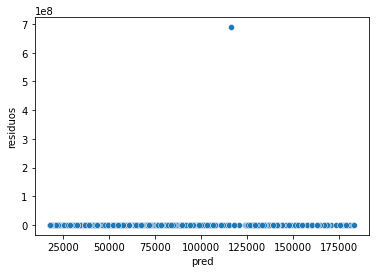

In [17]:
test_df["residuos"] = test_df["ingreso_neto_comprobado"] - test_df["pred"]
sns.scatterplot(y="residuos",x="pred", data=test_df)

In [18]:
from income.utils import normalize_core
core = pd.read_csv("data/aprobados.csv", index_col=0)

core = normalize_core(core)

In [19]:

cols = [col for col in core if col not in test_df.columns]
eval_df = pd.merge(core[cols],test_df,how="inner",left_index=True,right_index=True)

eval_df["real"] = eval_df["ingreso_neto_comprobado"]
eval_df["declarado"] = eval_df["net_income_verified"]

ingresos = ["real","declarado","pred"]

for ingreso in ingresos:
    eval_df[f"%_flag_{ingreso}"] = abs(eval_df["net_income_verified"]-eval_df[ingreso])/eval_df[ingreso]
    eval_df[f"%_flag_{ingreso}"]= np.where((eval_df[f"%_flag_{ingreso}"]>=0.5), 1,0)
    eval_df[f"capacidad_{ingreso}"] = (eval_df[ingreso] - eval_df['descuentos'])/(eval_df["Monto_de_la_mensualidad"])
    eval_df[f"CAP_{ingreso}"]= np.where((eval_df[f"capacidad_{ingreso}"]>=2), 1,0)
    eval_df[f"CAP_{ingreso}"]= np.where((eval_df[f"CAP_{ingreso}"]==0), "Desaprobado","Aprobado")

In [20]:
cols = [col for col in eval_df.columns if col not in test_df.columns]


In [21]:
cols

['perfil',
 'BC_Score_',
 'Monto_de_la_mensualidad',
 'descuentos',
 'Dependientes',
 'Ingreso_',
 'Ing_Disp',
 'real',
 'declarado',
 '%_flag_real',
 'capacidad_real',
 'CAP_real',
 '%_flag_declarado',
 'capacidad_declarado',
 'CAP_declarado',
 '%_flag_pred',
 'capacidad_pred',
 'CAP_pred']

from pivottablejs import pivot_ui

from IPython.display import HTML
from pivottablejs import pivot_ui

pivot_ui(eval_df[cols])
HTML('pivottablejs.html')

In [ ]:
models = ["Validado","ingreso_declarado" ]

test = predict_multiple_models(test, models, path_models)


In [ ]:

test = pd.merge(core[cols],test,how="inner",left_index=True,right_index=True)
test["validated_final_model"] = test["net_income_verified"]*test["Validado"]
test["validated_final_model"] =  test["validated_final_model"].astype(int)

In [ ]:
test["real"] = test["ingreso_neto_comprobado"]

In [ ]:
preds = ["validated_final_model","ingreso_declarado","real"]
for model in preds:
    test[f"%_flag_{model}"] = abs(test["net_income_verified"]-test[model])/test[model]
    test[f"%_flag_{model}"]= np.where((test[f"%_flag_{model}"]>=0.5), 1,0)
    test[f"capacidad_{model}"] = (test[model] - test['descuentos'])/(test["Monto_de_la_mensualidad"])
    test[f"CAP_{model}"]= np.where((test[f"capacidad_{model}"]>=2), 1,0)
    test[f"CAP_{model}"]= np.where((test[f"CAP_{model}"]==0), "Desaprobado","Aprobado")


In [ ]:
#Cuantos son perfil_X
#filtrar a los perfilx
    #cuantos CAP_ingreso_declarado rechazado
    #CAP_real rechazo y aprobado

In [ ]:
(test["rule"] == "Perfil_X").sum()

In [ ]:
len(test.loc[(test["rule"] == "Perfil_X")])/len(test)

In [ ]:
len(test)

In [ ]:
perfil_df = test.loc[(test["rule"]== "Perfil_X")]

In [ ]:
perfil_df.CAP_ingreso_declarado.value_counts(normalize=True)

In [ ]:
perfil_df.CAP_real.value_counts(normalize=True)

In [ ]:
pd.crosstab(perfil_df.CAP_ingreso_declarado,perfil_df.CAP_real)

In [ ]:
len(perfil_df.loc[(perfil_df.CAP_real == "Aprobado") & (perfil_df.CAP_ingreso_declarado == "Aprobado")])

In [ ]:
#grafico de residuos
#perfiles x cantidad

In [ ]:
core = pd.read_csv("s3://data-science-kavak-dev/projects/cerberus/v2/dev/income/data/aprobados.csv")
cols = [col for col in core if col not in test_df.columns]
core = pd.merge(core[cols],test_df,how="inner",left_index=True,right_index=True)

In [ ]:
#calculo capacidad de pago con declarada
#calculo capacidad de pago con real
#calculo capacidad de pago con pred

#cuento aprobado con declarada y rechazada con real y perfil x
#cuento aprobado con declarada y rechazada con pred y perfil x% (porcentaje de perfil x que voy ar echazar) 

In [ ]:
core

In [ ]:
#no llega al 1%

* Hacer este calculo
* scatterplot Residuos vs Predicho
* 

In [ ]:
# cuantos son perfiles X

In [ ]:
5000 test - mape 0.152 - % FLGS (40% --->50% de distancia con respecto a declarado y predicho)

In [ ]:
0.4*27090 FLAGS

In [ ]:
Perfil X 40% y listo

## Modelo % validado

In [29]:
lgbm.target

'target'

In [33]:
validated_train = train.copy()
validated_train["target"] = (validated_train["ingreso_neto_comprobado"]/validated_train["net_income_verified"])
del validated_train["ingreso_neto_comprobado"]

validated_test = test_df.copy()
validated_test["target"] = (validated_test["ingreso_neto_comprobado"]/validated_test["net_income_verified"])
del validated_test["ingreso_neto_comprobado"]


lgbm = LigthTrainer()
lgbm.fit(validated_train,model_name="validado", to_drop=['researchable_id', 'estimate', 'declarativa'], target="target")
lgbm.X_train = validated_train[lgbm.columns]
lgbm.y_train = validated_train[lgbm.target]
lgbm.X_test = validated_test[lgbm.columns]
lgbm.y_test = validated_test[lgbm.target]

lgbm.optimize()
lgbm.evaluate()
lgbm.save_model("%_validado")

Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 12790.2
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[322]	valid_0's l2: 12790.1
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[184]	valid_0's l2: 12790.2
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[102]	valid_0's l2: 12790.1
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[498]	valid_0's l2: 12790.1
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[64]	valid_0's l2: 12790.1
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[222]	valid_0's l2: 12790.2
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is

In [ ]:
lgbm = LigthTrainer()
lgbm.X_train = train[columnas]
lgbm.y_train = train[target]
lgbm.X_test = test_df[columnas]
lgbm.y_test = test_df[target]

lgbm.optimize()
lgbm.evaluate()
lgbm.save_model("preds_declarado")